<div class="alert alert-success" role="alert">
  <h1 class="alert-heading">Regresión Lineal Multivariado: PLS</h1>
  <h3 class="alert-heading">Prof. Enrique Mejía Ospino, emejia@uis.edu.co</h3>
  <h4 class="alert-heading">Escuela de Química</h4>
  <h5 class="alert-heading">Universidad Industrial de Santander</h5>
  <p>
  </div>

In [2]:
#from sklearn import datasets
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_predict, KFold, StratifiedKFold, train_test_split, cross_validate, cross_val_score
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn import preprocessing
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
import scipy.io #scipy.io me permite leer datos construidos en matlab
from scipy import stats # importando scipy.stats
from scipy.signal import savgol_filter
import scipy as sio
%matplotlib inline

**<font color=blue> Vamos  atilizar para este ejemplo dos archivos en formato de Matlab que contienen (espectros.mat), el primero, las intensidades de espectros FTICR de 40 muestras crudos fracciones y el segundo (propiedad.mat) el valor medido de una propiedad ccr de las muestras.** 

In [3]:
espectros = scipy.io.loadmat('data_ms_ccr.mat')# 
propiedad = scipy.io.loadmat('prop_ccr.mat')#

In [4]:
espectros['data1'].shape, propiedad['data'].shape # miramos la forma para ver si concuerdan, en este
# caso 40 muestras y 59692 señales de masas

((40, 59692), (40, 1))

In [5]:
data_prop=propiedad['data']
data_signals=espectros['data1']
#xftir=np.transpose(xftir)# usamos la transpuesta del archivo si es necesario

**<font color=blue> Se realizará un sencillo pre-procesamiento a los espectros, para este ejemplo, podemos escalar los datos con la función StandardScaler o Normalizar con la función Normalizer.  Escogeremos alguna de las dos y luego hacemos la Regresión lineal.** 

In [6]:
#normalizamos los datos
scaler=StandardScaler()
norma=Normalizer()

scaler.fit(data_signals) # calculo la media para poder hacer la transformacion
x_scaled=scaler.transform(data_signals)# Ahora si, escalo los datos y los normalizo
x_norm = preprocessing.normalize(data_signals, norm='l1')# Normaliza los datos
x_nsd = savgol_filter(x_norm, 17, polyorder=2, deriv=2) # Realiza segunda derivada de los datos

**<font color=green> Ahora realizamos el modelo de regresión lineal utilizando el grupo de entrenamiento y graficamos el resultado en terminos de los datos de calibración.** 

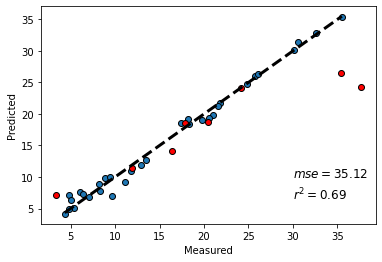

MSE = 35.12


In [10]:
# Separación de los datos en set de entrenamiento y set de prueba
x_train, x_test, y_train, y_test = train_test_split(x_norm, data_prop, train_size=0.8, random_state=4, shuffle= True)

pls = PLSRegression(n_components=10)
pls.fit(x_train, y_train)

y_pred = pls.predict(x_train)
y_pred_test = pls.predict(x_test)
fig, ax = plt.subplots()
ax.scatter(y_train, y_pred, edgecolors=(0, 0, 0))
ax.scatter(y_test, y_pred_test, color='red', edgecolors=(0, 0, 0))
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=3)
ax.text(30,10, r"$mse = "+str(round(mean_squared_error(y_test, y_pred_test), 2))+r"$", fontsize=12, color="black")
ax.text(30,6.5, r"$r^2 = "+str(round(r2_score(y_test, y_pred_test), 2))+r"$", fontsize=12, color="black")
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()
print('MSE = ' + str(round(mean_squared_error(y_test, y_pred_test), 2)))

In [11]:
def optimise_pls(X, y, xt, n_comp):
    
    # Definimos PLS y el número de componentes
    pls = PLSRegression(n_components=n_comp)
    pls.fit(X, y)
    y_pred1 = pls.predict(X)
    y_pred2 = pls.predict(xt)
    # Calculamos métricas
    r2 = r2_score(y, y_pred1)
    mse = mean_squared_error(y, y_pred1)
    rpd = y.std()/np.sqrt(mse)
    
    return (y_pred1, y_pred2, r2, mse, rpd)

In [12]:
# Probamos con 30 componentes
r2s = []
mses = []
rpds = []
yp1 = []
yp2 = []
arr_comp = np.arange(1, 31)
for n_comp in arr_comp:
    y_pred1, y_pred2, r2, mse, rpd = optimise_pls(x_train, y_train, x_test, n_comp)
    r2s.append(r2)
    mses.append(mse)
    rpds.append(rpd)
    yp1.append(y_pred1)
    yp2.append(y_pred2)

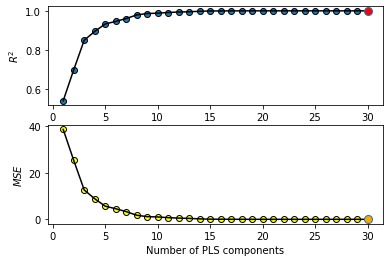

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1)
#fig, ax = plt.subplots()
ax1.scatter(arr_comp, r2s, edgecolors=(0, 0, 0))
ax1.plot(arr_comp, r2s, 'k-')
ax1.plot(arr_comp[np.argmax(r2s)], np.array(r2s)[np.argmax(r2s)], 'o', ms=8, mfc='red')
ax1.set_xlabel('Number of PLS components')
ax1.set_ylabel('$R^2$')

ax2.scatter(arr_comp, mses, color='yellow', edgecolors=(0, 0, 0))
ax2.plot(arr_comp, mses, 'k-')
ax2.plot(arr_comp[np.argmin(mses)], np.array(mses)[np.argmin(mses)], 'o', ms=8, mfc='orange')
ax2.set_xlabel('Number of PLS components')
ax2.set_ylabel('$MSE$')
plt.show()

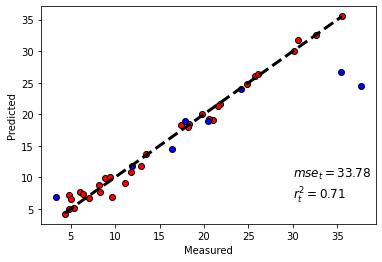

MSE = 1.14


In [16]:
fig, ax = plt.subplots()
ax.scatter(y_train, yp1[8], color='red', edgecolors=(0, 0, 0))
ax.scatter(y_test, yp2[10], color='blue', edgecolors=(0, 0, 0))
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=3)
ax.text(30,10, r"$mse_t = "+str(round(mean_squared_error(y_test, yp2[10]), 2))+r"$", fontsize=12, color="black")
ax.text(30,6.5, r"$r_t^2 = "+str(round(r2_score(y_test, yp2[10]), 2))+r"$", fontsize=12, color="black")
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()
print('MSE = ' + str(round(mean_squared_error(y_train, yp1[8]), 2)))

**<font color=black> Seguidamente vamos a realizar un modelo *PLS* utilizando *K-fold* y evaluando cada uno de los modelos originados de las diferentes separaciones através de las métricas $R^2$ y $MSE$.** 

In [12]:
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score
kf = KFold(n_splits=5, shuffle=True, random_state=42) # Vamos hacer 10 separaciones sin barajar en cada separación
model=PLSRegression(n_components=10) # Utilizamos 10 componentes de ajuste del modelo con PLS
x_traint = [] # Creamos arreglos de cada grupo de datos en los que almacenamos las diferentes divisiones 
x_testt = [] # Luego podremos utilizar la mejor separación para obtener el modelo más apropiado
y_traint = []
y_testt = []
r2s = []
mses = []

i = 1
for train_index, test_index in kf.split(x_norm):
    x_train = x_norm[train_index]
    x_test = x_norm[test_index]
    y_train = data_prop[train_index]
    y_test = data_prop[test_index]
    model.fit(x_train, y_train) #Training the model
    mse = mean_squared_error(y_test, model.predict(x_test))
    r2= r2_score(y_test, model.predict(x_test))
    
    # Almacenamos cada grupo en los arreglos creados
    x_traint.append(x_train) 
    x_testt.append(x_test)
    y_traint.append(y_train)
    y_testt.append(y_test)
    r2s.append(r2)
    mses.append(mse)
   
    # Entrenamos el modelo para cada separación the model
    model.fit(x_train, y_train) #Training the model
    print(f"MSE. {i} on the test set: {mean_squared_error(y_test, model.predict(x_test))}")
    print(f"R2. {i} on the test set: {r2_score(y_test, model.predict(x_test))}")
    i += 1

MSE. 1 on the test set: 22.044327712665858
R2. 1 on the test set: 0.8326152091185951
MSE. 2 on the test set: 27.50613309276797
R2. 2 on the test set: 0.704895780706333
MSE. 3 on the test set: 9.52312121228535
R2. 3 on the test set: 0.8615493239279467
MSE. 4 on the test set: 40.77132410709426
R2. 4 on the test set: 0.5634176413154519
MSE. 5 on the test set: 11.167185021593102
R2. 5 on the test set: 0.6468730363851498


**<font color=red> Vamos a convertir el mejor set (el de mejor comportamiento) en arreglos númerico y luego seran usados para construir el modelo PLS.** 

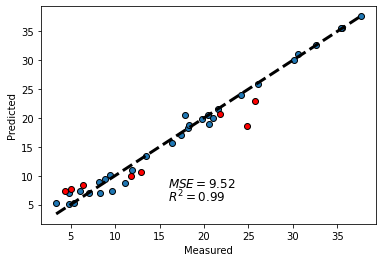

In [14]:
y_tr=np.array(y_traint[r2s.index(max(r2s))]) # Escogemos el mejor set a partir del que presente el
y_te=np.array(y_testt[r2s.index(max(r2s))]) # el valor máximo de r2. Podríamos también elegir el que
X_tr=np.array(x_traint[r2s.index(max(r2s))]) # presente el menor valor del mse
X_te=np.array(x_testt[r2s.index(max(r2s))])
model.fit(X_tr, y_tr) # Ejecutamos el modelo PLS con el set de entranamiento de mejor comportamiento

Y_pred = model.predict(X_tr) # Con el modelo predicmos los valos de la propiedad
Y_pred_test = model.predict(X_te) # Evaluamos las muestras de prueba

fig, ax = plt.subplots()
ax.scatter(y_tr, Y_pred, edgecolors=(0, 0, 0))
ax.scatter(y_te, Y_pred_test, color='red', label='test set', edgecolors=(0, 0, 0))
ax.plot([y_tr.min(), y_tr.max()], [y_tr.min(), y_tr.max()], 'k--', lw=3)
ax.text(30,8, r"$MSE = "+str("{0:.2f}".format(mean_squared_error(y_te, Y_pred_test)))+r"$", fontsize=12, color="black")
ax.text(30,5.5, r"$R^2 = "+str("{0:.2f}".format(r2_score(y_tr, Y_pred)))+r"$", fontsize=12, color="black")
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()